In [1227]:
from pandas import Series
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from os import listdir

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve


from main import df_scrolling_object

import my_func
import importlib
# importlib.reload(main)
importlib.reload(my_func)

from pandas_profiling import ProfileReport

In [1228]:
input_folder = 'input/'
listdir(input_folder)

[&#39;train.csv&#39;]

| Столбец        |     Значение                    |
|:---------------|:--------------------------------|
|client_id	     |    идентификатор клиента        |  
|education	     |   уровень образования           | 
|sex	         | пол заёмщика  
|age             |	возраст заёмщика  
|car	         |флаг наличия автомобиля  
|car_type	     |флаг автомобиля-иномарки  
|decline_app_cnt |	количество отказанных прошлых заявок  
|good_work       |	флаг наличия «хорошей» работы  
|bki_request_cnt |	количество запросов в БКИ  
|home_address	 |категоризатор домашнего адреса  
|work_address	 |категоризатор рабочего адреса  
|income	         |доход заёмщика  
|foreign_passport|	наличие загранпаспорта  
|sna | связь заемщика с клиентами банка
|first_time | давность наличия информации о заемщике
|score_bki | скоринговый балл по данным из БКИ
|region_rating | рейтинг региона
|app_date | дата подачи заявки
|default	     |наличие дефолта  

In [1229]:
# data = pd.read_csv(input_folder + 'train.csv')
# data.drop(['client_id'],  axis=1, inplace=True)

data_train = pd.read_csv('kaggle/train.csv')

data_subm = pd.read_csv('kaggle/sample_submission.csv')
data_test = pd.read_csv('kaggle/test.csv')
# print(data.shape, data_test.shape, data_subm.shape)
data_train['train'] = 1 # помечаем где у нас трейн
data_test['train'] = 0 # помечаем где у нас тест
data = data_train.append(data_test, sort=False).reset_index(drop=True)

In [1230]:
bin_cols = ['good_work', 'foreign_passport', 'car', 'car_type', 'sex' ]
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income', 'score_bki']
cat_cols = ['education', 'home_address' , 'work_address', 'first_time', 'sna' , 'region_rating']
(bin_cols + num_cols + cat_cols)

[&#39;good_work&#39;,
 &#39;foreign_passport&#39;,
 &#39;car&#39;,
 &#39;car_type&#39;,
 &#39;sex&#39;,
 &#39;age&#39;,
 &#39;decline_app_cnt&#39;,
 &#39;bki_request_cnt&#39;,
 &#39;income&#39;,
 &#39;score_bki&#39;,
 &#39;education&#39;,
 &#39;home_address&#39;,
 &#39;work_address&#39;,
 &#39;first_time&#39;,
 &#39;sna&#39;,
 &#39;region_rating&#39;]

In [1231]:
# переведем признак data.score_bki к положительным значениям, чтобы проще можно было логорифмировать
data.score_bki = data.score_bki - data.score_bki.min() 

In [1232]:
edu_income_rel = dict({'SCH': list([0, 31960.275039]),
                       'UGR': list([31960.275039,39391.796251]),
                       'GRD': list([39391.796251, 54663.948941]),
                       'PGR': list([54663.948941, 77548.206046]),
                       'ACD': list([77548.206046, 999999999999])})

def fill_edu(income, edu_income_rel):
    for edu, income_edu in edu_income_rel.items():
         if income_edu[0] < income <  income_edu[1]:
             return edu

na_index = data[data.education.isna()].index

data['education_isNAN'] = pd.isna(data.education).astype('uint8')

for index in na_index:
    inc = data.income.iloc[index]
    data.education.iloc[index] = fill_edu(inc, edu_income_rel)

### Собираем дату

In [1233]:
data.app_date = pd.to_datetime(data.app_date)
data['month'] = data.app_date.dt.month
data['day'] = data.app_date.dt.day
data['year'] = data.app_date.dt.year
data.drop('app_date', axis=1, inplace=True)

# ВЫБРОСЫ !!!!!!!   
Все нумерные признаки оставляем с выбросами, как таковые выбросы были   
обнаружены в колонке дохода, но для любого сокращенного диапазона по этому признаку   
скор падает

In [1234]:
data[data.default==0].score_bki.mean()

1.6865381729461284

In [1235]:
data[data.default==1].score_bki.mean()

1.948949209981858

# Образование

In [1236]:
# data.groupby('default')['education'].hist()
# print(data.education.value_counts())

edu_dict = dict({'SCH': 0, #school
                 'GRD': 2, #out-student
                 'UGR': 1, #student
                 'PGR': 3, #aspirant
                 'ACD': 4})#academic 

# data['education_lvl'] = data['education'].map(edu_dict)
# data['education'] = data['education'].map(edu_dict)
data['education'] = data['education'].astype('category').cat.codes#
# data['education'] = data['education'].map(edu_dict)
# data.groupby(by='education').code_education.mean()

In [1237]:
# data.groupby('default')['car_type'].mean()

# PROFILER

In [1238]:
# profile = ProfileReport(data)
# profile.to_widgets()

# ГЕНЕРИРУЕМ !!!!!!!!!!

In [1239]:
data.groupby(by='education').default.mean().sort_values()


education
0    0.040179
2    0.064692
1    0.090114
4    0.131309
3    0.150593
Name: default, dtype: float64

In [1240]:
label_encoder = LabelEncoder()

for bin_col in bin_cols:
    data[bin_col] = label_encoder.fit_transform(data[bin_col])
# data['money_home_car'] = data['income'] - data['home_address'] * 1000 - data['car'] * 1000 - data['car_type'] * 1000
# data[bin_col]

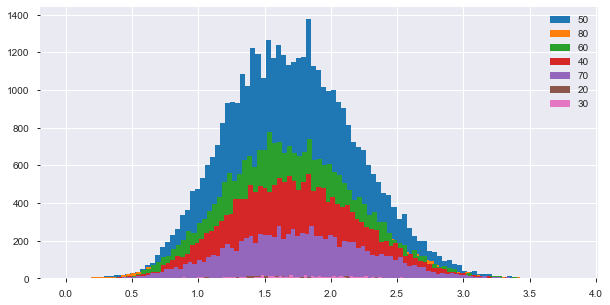

In [1241]:
# data['bki_on_power_count'] = data['']
# new_cols = ['bki_on_power_count']
# data[data.score_bki>3.5].sort_values(by='default')
plt.rcParams['figure.figsize'] = (10,5)


for region in data.region_rating.unique():
    data[(data.region_rating == region)].score_bki.hist(bins=100, label=region)
    plt.legend()

&lt;AxesSubplot:xlabel=&#39;region_rating&#39;&gt;

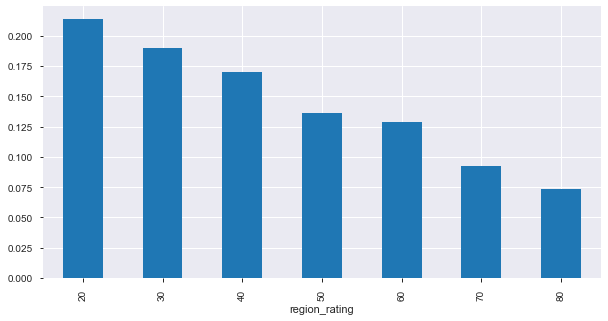

In [1242]:
for_plot = data.groupby(by='region_rating')['default'].mean()
for_plot.plot.bar()

&lt;AxesSubplot:xlabel=&#39;first_time&#39;&gt;

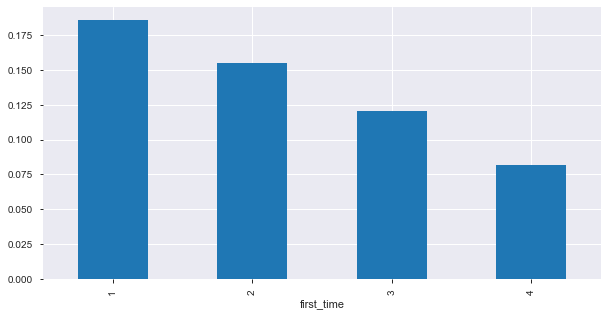

In [1243]:
for_plot = data.groupby(by='first_time')['default'].mean()
for_plot.plot.bar()

In [1244]:
data['region_firstt'] = data['region_rating'] / (data['first_time'])
# data['bki_to_count'] = data['score_bki'] / (data['bki_request_cnt'] + 0.01)


In [1245]:
# data['bki_to_count'].sort_values(ascending=False)
# data.drop(index=34773, inplace=True)

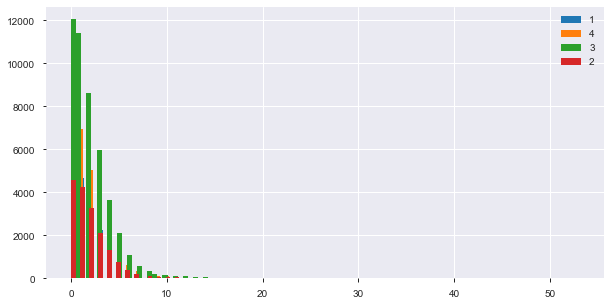

In [1246]:
for region in data.first_time.unique():
    data[(data.first_time == region)].bki_request_cnt.hist(bins=100, label=region)
    plt.legend()

In [1247]:
# добавим новый признак к списку категорий, чтобы он попал на логарифмирование и стандартизацию
num_cols = num_cols + ['region_firstt'] #+ ['bki_to_count']

In [1248]:
cat_cols

[&#39;education&#39;,
 &#39;home_address&#39;,
 &#39;work_address&#39;,
 &#39;first_time&#39;,
 &#39;sna&#39;,
 &#39;region_rating&#39;]

In [1249]:
bin_cols

[&#39;good_work&#39;, &#39;foreign_passport&#39;, &#39;car&#39;, &#39;car_type&#39;, &#39;sex&#39;]

# EDA

,age,decline_app_cnt,bki_request_cnt,income,score_bki,region_firstt
default,,,,,,
0.0,39.390504,0.240877,1.933134,41799.713288,1.686538,24.875647
1.0,38.525395,0.515472,2.462335,36288.113316,1.948949,27.551216


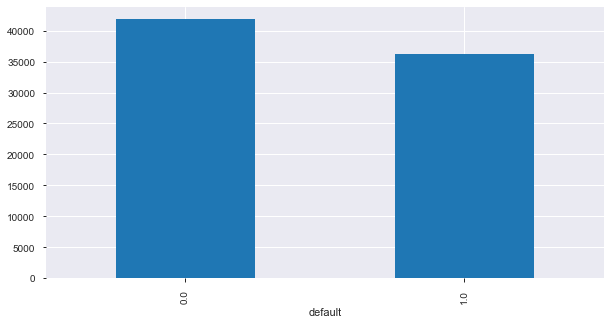

In [1250]:
for_plot = data.groupby(by='default')[num_cols].mean()
for_plot.age.plot.bar()
for_plot.income.plot.bar()
for_plot

&lt;AxesSubplot:xlabel=&#39;bki_request_cnt&#39;&gt;

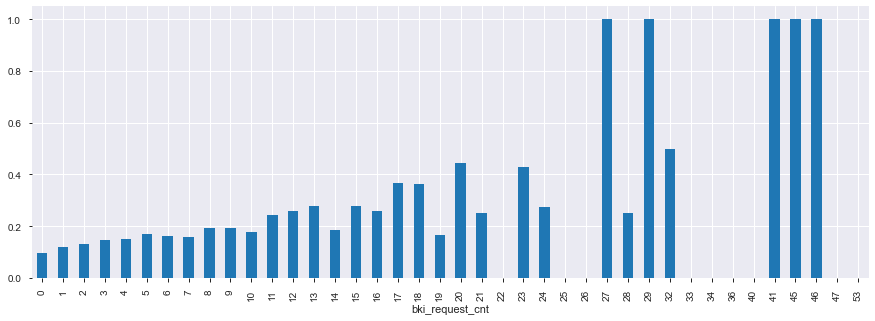

In [1251]:
plt.figure(figsize=(15,5))
data.groupby('bki_request_cnt').default.mean().plot.bar()


## Рассмотрим зависимости между некоторыми параметрами в связи с целевым.
## дефолт \ марка машины

,car_type,income,default
0,no car,33153.865554,0.136960
1,common car,40058.143367,0.132744
2,foreign car,69478.156417,0.087450


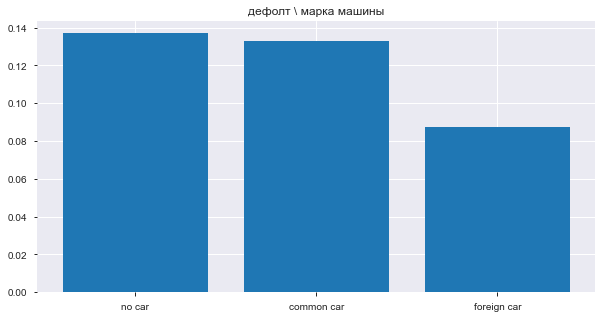

In [1252]:
for_plot = data.groupby(by=['car_type', 'car'])['income', 'default'].mean().reset_index()
for_plot['car_type'] =  for_plot['car_type'] + for_plot['car']
for_plot.car_type = for_plot.car_type.apply(lambda x: 'no car' if x==0 else 
                                                      'common car' if x==1 else 
                                                      'foreign car')
for_plot.drop('car', axis=1, inplace=True)

plt.bar(x=for_plot.car_type, height=for_plot.default)
plt.title('дефолт \ марка машины')
for_plot

## доход \ марка машины

Text(0.5, 1.0, &#39;доход \\ марка машины&#39;)

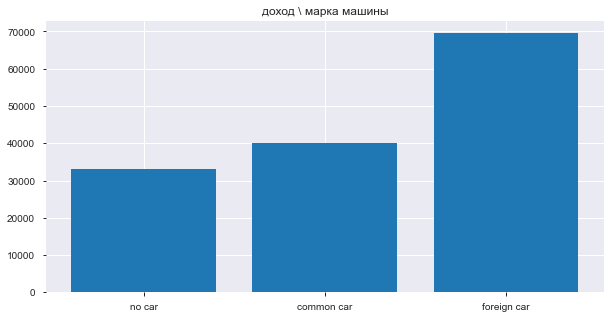

In [1253]:
plt.bar(x=for_plot.car_type, height=for_plot.income)
plt.title('доход \ марка машины')

Вывод: с господами с иномарками реже случается дефолт, так же они в среднем довольно больше зарабатывают

Text(0.5, 1.0, &#39;доход \\ категория домашнего адреса&#39;)

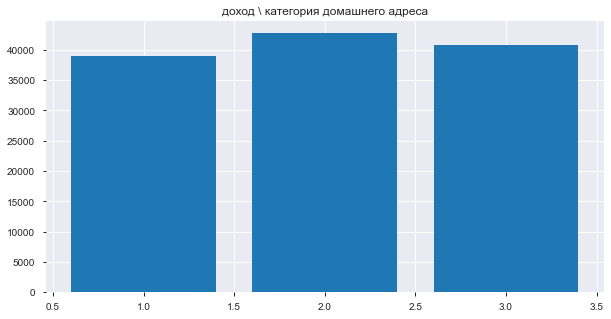

In [1254]:
for_plot = data.groupby(by=['home_address'])['income', 'default'].mean()
plt.bar(x=for_plot.index, height=for_plot.income)
plt.title('доход \ категория домашнего адреса')

Text(0.5, 1.0, &#39;дефолт \\ категория домашнего адреса&#39;)

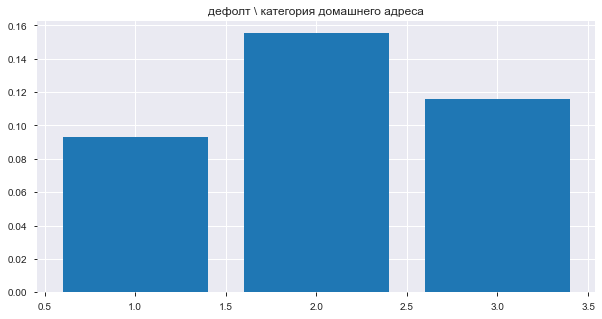

In [1255]:
plt.bar(x=for_plot.index, height=for_plot.default)
plt.title('дефолт \ категория домашнего адреса')

Вывод: Дефолтные юниты проживающие во второй категории встречаются чаще.

# Определение важности признаков

&lt;AxesSubplot:&gt;

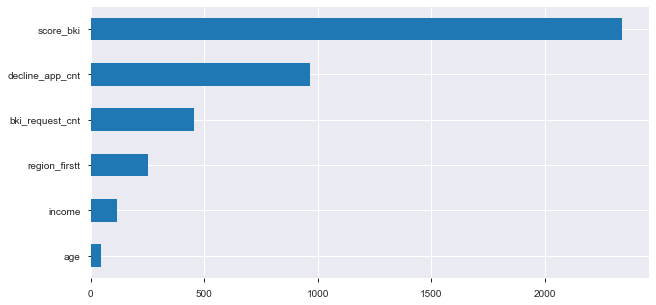

In [1256]:
data_num = data[data.train==1].copy()
imp_num = Series(f_classif(data_num[num_cols], data_num['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [1257]:
# label_encoder = LabelEncoder()

# for bin_col in bin_cols:
#     data[bin_col] = label_encoder.fit_transform(data[bin_col])

# data.education = data.education.astype('category').cat.codes

&lt;AxesSubplot:&gt;

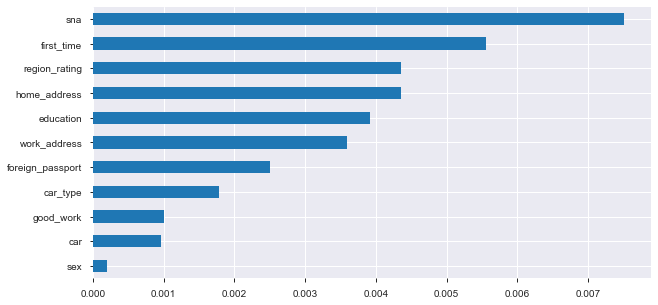

In [1258]:
data_cat = data[data.train==1].copy()
imp_cat = Series(mutual_info_classif(data_cat[bin_cols + cat_cols], data_cat['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [1259]:
data = pd.get_dummies(data, columns=cat_cols, drop_first=False)

In [1260]:
data[num_cols] = data[num_cols].apply(lambda x: np.log(x + 1))

In [1261]:
# Стандартизация числовых переменных

data[num_cols] = StandardScaler().fit_transform(data[num_cols].values)

In [1262]:
import main
from main import df_scrolling_object
import importlib
importlib.reload(main)

# data_obj = df_scrolling_object(data)
# X, Y = data_obj.return_XY()

X = data[data.train==1].drop(['default'], axis=1)
Y = data[data.train==1]['default']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

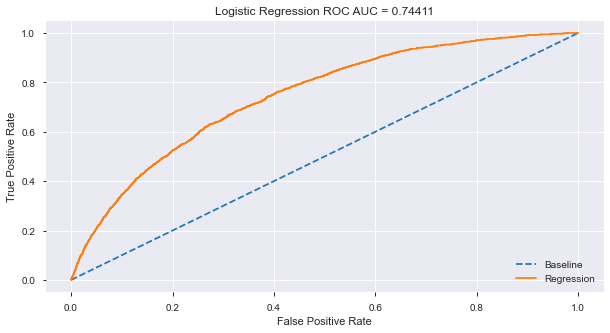

roc_auc=0.74411  C=1   penalty=l2 solver=newton-cg
[[12876    57]
 [ 1793    34]]


In [1263]:
C = 1
penalty = 'l2'
solver = 'newton-cg'

model = LogisticRegression(C=C, penalty=penalty, solver = solver)
model.fit(X_train, y_train)

probs = model.predict_proba(X_test)
y_pred = model.predict(X_test)
probs = probs[:,1]

fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.5f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

print(f'roc_auc={round(roc_auc, 6)}  C={C}   penalty={penalty} solver={solver}')
print(confusion_matrix(y_test, y_pred))

In [1264]:
# from sklearn.model_selection import GridSearchCV
# # Добавим типы регуляризации
# penalty = ['l1', 'l2']
# # Зададим ограничения для параметра регуляризации
# C = np.logspace(0, 4, 10)
# # solver
# solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

# # Создадим гиперпараметры
# hyperparameters = dict(C=C, penalty=penalty, solver=solver)

# model = LogisticRegression()
# model.fit(X_train, y_train)

# # Создаем сетку поиска с использованием 5-кратной перекрестной проверки
# clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

# best_model = clf.fit(X_train, y_train)

# # View best hyperparameters
# print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
# print('Лучшее C:', best_model.best_estimator_.get_params()['C'])
# print('Лучшее Solver:', best_model.best_estimator_.get_params()['solver'])

In [1265]:
# from sklearn.feature_selection import RFE


# estimator = model
# selector = RFE(estimator, n_features_to_select=40, step=1)
# selector = selector.fit(X, Y)
# true_features_mask = selector.support_
# X = selector.transform(X)

In [1266]:
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

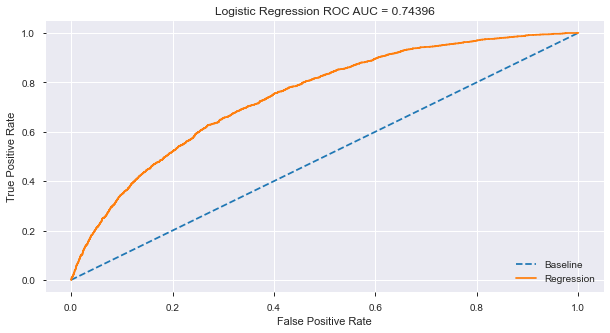

roc_auc=0.743956  C=1291.5496650148827   penalty=l1 solver=liblinear
[[12875    58]
 [ 1793    34]]


In [1267]:
# C = 1291.5496650148827
# penalty = 'l1'
# solver = 'liblinear'

# model = LogisticRegression(C=C, penalty=penalty, solver = solver)
# model.fit(X_train, y_train)

# probs = model.predict_proba(X_test)
# y_pred = model.predict(X_test)
# probs = probs[:,1]

# fpr, tpr, threshold = roc_curve(y_test, probs)
# roc_auc = roc_auc_score(y_test, probs)

# plt.figure()
# plt.plot([0, 1], label='Baseline', linestyle='--')
# plt.plot(fpr, tpr, label = 'Regression')
# plt.title('Logistic Regression ROC AUC = %0.5f' % roc_auc)
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.legend(loc = 'lower right')
# plt.show()

# print(f'roc_auc={round(roc_auc, 6)}  C={C}   penalty={penalty} solver={solver}')
# print(confusion_matrix(y_test, y_pred))

roc_auc=0.744112  C=1   penalty=l2 solver=newton-cg  
roc_auc=0.744088  C=1   penalty=l2 solver=newton-cg  
roc_auc=0.743984  C=1   penalty=l2 solver=newton-cg  
roc_auc=0.7439  C=1   penalty=l2 solver=newton-cg   
roc_auc=0.743433  C=1                 penalty=l2 solver=newton-cg   
roc_auc=0.677348   
roc_auc=0.677304   
roc_auc=0.677311  C=1  penalty=l2 solver=newton-cg  
roc_auc=0.677277  C=2.7825594022071245  penalty=l2 solver=

In [1268]:
# from sklearn.model_selection import GridSearchCV
# # Добавим типы регуляризации
# penalty = ['l1', 'l2']
# # Зададим ограничения для параметра регуляризации
# C = np.logspace(0, 4, 10)
# # solver
# solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

# # Создадим гиперпараметры
# hyperparameters = dict(C=C, penalty=penalty, solver=solver)

# model = LogisticRegression()
# model.fit(X_train, y_train)

# # Создаем сетку поиска с использованием 5-кратной перекрестной проверки
# clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

# best_model = clf.fit(X_train, y_train)

# # View best hyperparameters
# print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
# print('Лучшее C:', best_model.best_estimator_.get_params()['C'])
# print('Лучшее Solver:', best_model.best_estimator_.get_params()['solver'])

Лучшее Penalty: l1
Лучшее C: 1291.5496650148827
Лучшее Solver: liblinear

X_test = data[data.train==0].drop('default', axis=1)
y_pred_subm = model.predict_proba(X_test)[:,1]

submit = pd.DataFrame(X_test.client_id)
submit['default'] = y_pred_subm
submit.to_csv('submission.csv', index=False)